# q1_softmax 

In [3]:
import numpy as np
import random

def softmax(x):
    
    if len(x.shape) > 1:
        tmp = np.max(x, axis = 1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis = 1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp
    
    return x

### Test for softmax function

In [4]:
def test_softmax_basic():
    """
    Some simple tests to get you started. 
    Warning: these are not exhaustive.
    """
    print "Running basic tests..."
    test1 = softmax(np.array([1,2]))
    print test1
    assert np.amax(np.fabs(test1 - np.array(
        [0.26894142,  0.73105858]))) <= 1e-6

    test2 = softmax(np.array([[1001,1002],[3,4]]))
    print test2
    assert np.amax(np.fabs(test2 - np.array(
        [[0.26894142, 0.73105858], [0.26894142, 0.73105858]]))) <= 1e-6

    test3 = softmax(np.array([[-1001,-1002]]))
    print test3
    assert np.amax(np.fabs(test3 - np.array(
        [0.73105858, 0.26894142]))) <= 1e-6

    print "Passed!\n"
    
test_softmax_basic()

Running basic tests...
[ 0.26894142  0.73105858]
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]
[[ 0.73105858  0.26894142]]
Passed!



# q2 sigmoid
- sigmoid
- gradient of sigmoid
- test for the above

In [5]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    x = 1. / (1 + np.exp(-x))
    
    return x

def sigmoid_grad(f):
    """
    Compute the gradient for the sigmoid function here. Note that
    for this implementation, the input f should be the sigmoid
    function value of your original input x. 
    """
    f = f * (1-f)
    
    return f

def test_sigmoid_basic():
    """
    Some simple tests to get you started. 
    Warning: these are not exhaustive.
    """
    print "Running basic tests..."
    x = np.array([[1, 2], [-1, -2]])
    f = sigmoid(x)
    g = sigmoid_grad(f)
    print f
    assert np.amax(f - np.array([[0.73105858, 0.88079708], 
        [0.26894142, 0.11920292]])) <= 1e-6
    print g
    assert np.amax(g - np.array([[0.19661193, 0.10499359],
        [0.19661193, 0.10499359]])) <= 1e-6
    print "You should verify these results!\n"

test_sigmoid_basic()

Running basic tests...
[[ 0.73105858  0.88079708]
 [ 0.26894142  0.11920292]]
[[ 0.19661193  0.10499359]
 [ 0.19661193  0.10499359]]
You should verify these results!



# q2 Gradient checking
Reference : http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/ 

In [6]:
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    - Reference : http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/ 
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, gd = f(x) # Evaluate function value at original point
    h = 1e-4

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        
        x[ix] += h
        random.setstate(rndstate)
        fx_p, _ = f(x)
        x[ix] -= 2*h
        random.setstate(rndstate)
        fx_n, _ = f(x)
        x[ix] += h
        grad = (fx_p - fx_n) / (2*h)
        
        diff = abs(grad - gd[ix]) / max(1, abs(grad), abs(gd[ix]))
        
        if diff > 1e-5:
            print "Gradient check failed."
            print "First gradient error found at index %s" % str(ix)
            print "Your gradient: %f \t Numerical gradient: %f" % (gd[ix], grad)
            return

    
        it.iternext() # Step to next dimension

    print "Gradient check passed!"

def sanity_check():
    """
    Some basic sanity checks.
    """
    quad = lambda x: (np.sum(x ** 2), x * 2)

    print "Running sanity checks..."
    gradcheck_naive(quad, np.array(123.456))      # scalar test
    gradcheck_naive(quad, np.random.randn(3,))    # 1-D test
    gradcheck_naive(quad, np.random.randn(4,5))   # 2-D test
    print ""

sanity_check()

Running sanity checks...
Gradient check passed!
Gradient check passed!
Gradient check passed!



# q2 neural net
Reference : http://neuralnetworksanddeeplearning.com/chap2.html 

In [7]:
def forward_backward_prop(data, labels, params, dimensions):
    """ 
    Forward and backward propagation for a two-layer sigmoidal network 
    
    Compute the forward propagation and for the cross entropy cost,
    and backward propagation for the gradients for all parameters.
    """

    ### Unpack network parameters (do not modify)
    ofs = 0
    Dx, H, Dy = (dimensions[0], dimensions[1], dimensions[2])

    W1 = np.reshape(params[ofs:ofs+ Dx * H], (Dx, H))
    ofs += Dx * H
    b1 = np.reshape(params[ofs:ofs + H], (1, H))
    ofs += H
    W2 = np.reshape(params[ofs:ofs + H * Dy], (H, Dy))
    ofs += H * Dy
    b2 = np.reshape(params[ofs:ofs + Dy], (1, Dy))

    ### YOUR CODE HERE: forward propagation
    hidden = sigmoid( np.dot(data, W1) + b1)
    prediction = softmax( np.dot(hidden, W2) + b2)
    cost = -np.sum(np.log(prediction) * labels)
    ### END YOUR CODE
    
    ### YOUR CODE HERE: backward propagation
    ### reference : http://neuralnetworksanddeeplearning.com/chap2.html 
    delta = prediction - labels
    gradW2 = np.dot(hidden.T, delta) 
    gradb2 = np.sum(delta, axis = 0)
    delta = delta.dot(W2.T) * sigmoid_grad(hidden)
    gradW1 = data.T.dot(delta)
    gradb1 = np.sum(delta, axis = 0)
    ### END YOUR CODE
    
    ### Stack gradients (do not modify)
    grad = np.concatenate((gradW1.flatten(), gradb1.flatten(), 
        gradW2.flatten(), gradb2.flatten()))
    
    return cost, grad

def neural_sanity_check():
    """
    Set up fake data and parameters for the neural network, and test using 
    gradcheck.
    """
    print "Running sanity check..."

    N = 20
    dimensions = [10, 5, 10]
    data = np.random.randn(N, dimensions[0])   # each row will be a datum
    labels = np.zeros((N, dimensions[2]))
    for i in xrange(N):
        labels[i,random.randint(0,dimensions[2]-1)] = 1
    
    params = np.random.randn((dimensions[0] + 1) * dimensions[1] + (
        dimensions[1] + 1) * dimensions[2], )

    gradcheck_naive(lambda params: forward_backward_prop(data, labels, params,
        dimensions), params)

neural_sanity_check()

Running sanity check...
Gradient check passed!


# q3 word2vec 
## normalize rows

In [8]:
def normalizeRows(x):
    """ Row normalization function """
    # Implement a function that normalizes each row of a matrix to have unit length
    
    length = np.sqrt( np.sum(x**2, axis = 1))
    x /= length.reshape(x.shape[0],1)
    
    return x

def test_normalize_rows():
    print "Testing normalizeRows..."
    x = normalizeRows(np.array([[3.0,4.0],[1, 2]])) 
    # the result should be [[0.6, 0.8], [0.4472, 0.8944]]
    print x
    assert (x.all() == np.array([[0.6, 0.8], [0.4472, 0.8944]]).all())
    print ""
    
test_normalize_rows()

Testing normalizeRows...
[[ 0.6         0.8       ]
 [ 0.4472136   0.89442719]]



## softmax cost and gradient 

In [9]:
def softmaxCostAndGradient(predicted, target, outputVectors, dataset):
    """ Softmax cost function for word2vec models """
    
    # Implement the cost and gradients for one predicted word vector  
    # and one target word vector as a building block for word2vec     
    # models, assuming the softmax prediction function and cross      
    # entropy loss.                                                   
    
    # Inputs:                                                         
    # - predicted: numpy ndarray, predicted word vector (\hat{v} in 
    #   the written component or \hat{r} in an earlier version)
    # - target: integer, the index of the target word               
    # - outputVectors: "output" vectors (as rows) for all tokens     
    # - dataset: needed for negative sampling, unused here.         
    
    # Outputs:                                                        
    # - cost: cross entropy cost for the softmax word prediction    
    # - gradPred: the gradient with respect to the predicted word   
    #        vector                                                
    # - grad: the gradient with respect to all the other word        
    #        vectors                                               
    
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!                                                  
    
    ### Check solution for assignment q3 for reference
    ### predicted =  1,D ... output  =  V,D
    ### cost is cross entropy loss of probabilities[target]
    probabilities = softmax( np.dot(predicted, outputVectors.T))
    cost = - np.log(probabilities[target])
    
    ### delta = y_predicted - y, y_i = 0 except i == target
    delta = probabilities
    delta[target] -= 1
    
    gradPred = np.dot(delta.T,outputVectors)
    grad = np.dot(delta.reshape(delta.shape[0],1),predicted.reshape(1,predicted.shape[0]))
    
    return cost, gradPred, grad


# negative sample cost and gradient

In [10]:
def negSamplingCostAndGradient(predicted, target, outputVectors, dataset, 
    K=10):
    """ Negative sampling cost function for word2vec models """

    # Implement the cost and gradients for one predicted word vector  
    # and one target word vector as a building block for word2vec     
    # models, using the negative sampling technique. K is the sample  
    # size. You might want to use dataset.sampleTokenIdx() to sample  
    # a random word index. 
    # 
    # Note: See test_word2vec below for dataset's initialization.
    #                                       
    # Input/Output Specifications: same as softmaxCostAndGradient     
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!
    
    ### YOUR CODE HERE
    out_indices = [target]

    for k in range(K):
        index = dataset.sampleTokenIdx()
        while index == target:
            index = dataset.sampleTokenIdx()
        out_indices += [index]

    out_vectors = outputVectors[out_indices,:]

    labels = np.array([1] + [-1]* K)

    prediction = sigmoid( out_vectors.dot(predicted) * labels )
    cost = - np.sum(np.log(prediction))

    delta = labels * (prediction - 1)


    gradPred = delta.dot( out_vectors)

    gradTemp = (delta.reshape(K+1, 1)).dot(predicted.reshape(1, predicted.shape[0]))
    ### END YOUR CODE

    grad = np.zeros(outputVectors.shape)
    for index in range(K+1):
        grad[out_indices[index]] += gradTemp[index]

    
    ### END YOUR CODE
    
    return cost, gradPred, grad

## Skipgram model

In [11]:
def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """

    # Implement the skip-gram model in this function.

    # Inputs:                                                         
    # - currrentWord: a string of the current center word           
    # - C: integer, context size                                    
    # - contextWords: list of no more than 2*C strings, the context words                                               
    # - tokens: a dictionary that maps words to their indices in    
    #      the word vector list                                
    # - inputVectors: "input" word vectors (as rows) for all tokens           
    # - outputVectors: "output" word vectors (as rows) for all tokens         
    # - word2vecCostAndGradient: the cost and gradient function for 
    #      a prediction vector given the target word vectors,  
    #      could be one of the two cost functions you          
    #      implemented above

    # Outputs:                                                        
    # - cost: the cost function value for the skip-gram model       
    # - grad: the gradient with respect to the word vectors         
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!

    ### YOUR CODE HERE
    
    # v_c
    index_center = tokens[currentWord]
    predicted = inputVectors[index_center, :]  
    
    cost = 0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)
    
    
    for word in contextWords:
        index = tokens[word]
        cost_w, gradP, grad = word2vecCostAndGradient(predicted, index, outputVectors, dataset)
        cost += cost_w
        gradIn[index_center, : ] += gradP
        gradOut += grad
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

## CBOW model 

In [12]:
def cbow(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ CBOW model in word2vec """

    # Implement the continuous bag-of-words model in this function.            
    # Input/Output specifications: same as the skip-gram model        
    # We will not provide starter code for this function, but feel    
    # free to reference the code you previously wrote for this        
    # assignment!

    #################################################################
    # IMPLEMENTING CBOW IS EXTRA CREDIT, DERIVATIONS IN THE WRIITEN #
    # ASSIGNMENT ARE NOT!                                           #  
    #################################################################
    
    cost = 0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)

    ### YOUR CODE HERE
    
    indexes = [tokens[word] for word in contextWords]
    predicted = np.zeros(( inputVectors.shape[1]))
    
    for index in indexes:
        predicted += inputVectors[index,:]
    
    #print "indexes: " ,indexes
    
    cost, gradP, gradOut = word2vecCostAndGradient(predicted, tokens[currentWord], outputVectors, dataset)
    
    for index in indexes:
        gradIn[index,:] += gradP 
    
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

# Test word2vec

In [13]:
#############################################
# Testing functions below. DO NOT MODIFY!   #
#############################################

def word2vec_sgd_wrapper(word2vecModel, tokens, wordVectors, dataset, C, word2vecCostAndGradient = softmaxCostAndGradient):
    batchsize = 50
    cost = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    inputVectors = wordVectors[:N/2,:]
    outputVectors = wordVectors[N/2:,:]
    for i in xrange(batchsize):
        C1 = random.randint(1,C)
        centerword, context = dataset.getRandomContext(C1)
        
        if word2vecModel == skipgram:
            denom = 1
        else:
            denom = 1
        
        c, gin, gout = word2vecModel(centerword, C1, context, tokens, inputVectors, outputVectors, dataset, word2vecCostAndGradient)
        cost += c / batchsize / denom
        grad[:N/2, :] += gin / batchsize / denom
        grad[N/2:, :] += gout / batchsize / denom
        
    return cost, grad

def test_word2vec():
    # Interface to the dataset for negative sampling
    dataset = type('dummy', (), {})()
    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0,4)], [tokens[random.randint(0,4)] \
           for i in xrange(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10,3))
    dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])
    print "==== Gradient check for skip-gram ===="
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5), dummy_vectors)
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)
    print "\n==== Gradient check for CBOW      ===="
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5), dummy_vectors)
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)

    print "\n=== Results ==="
    print skipgram("c", 3, ["a", "b", "e", "d", "b", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset)
    print skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset, negSamplingCostAndGradient)
    print cbow("a", 2, ["a", "b", "c", "a"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset)
    print cbow("a", 2, ["a", "b", "a", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset, negSamplingCostAndGradient)

test_word2vec()

==== Gradient check for skip-gram ====
Gradient check passed!
Gradient check passed!

==== Gradient check for CBOW      ====
Gradient check passed!
Gradient check passed!

=== Results ===
(11.166109001533981, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.26947339, -1.36873189,  2.45158957],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.41045956,  0.18834851,  1.43272264],
       [ 0.38202831, -0.17530219, -1.33348241],
       [ 0.07009355, -0.03216399, -0.24466386],
       [ 0.09472154, -0.04346509, -0.33062865],
       [-0.13638384,  0.06258276,  0.47605228]]))
(13.959405258751875, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-4.12113804, -1.67347865, -1.5049951 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.49853822,  0.22876535,  1.7401640

## Stochastic Gradient Descent

In [14]:
# Save parameters every a few SGD iterations as fail-safe
SAVE_PARAMS_EVERY = 1000

import glob
import random
import numpy as np
import os.path as op
import cPickle as pickle

def load_saved_params():
    """ A helper function that loads previously saved parameters and resets iteration start """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter
            
    if st > 0:
        with open("saved_params_%d.npy" % st, "r") as f:
            params = pickle.load(f)
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None
    
def save_params(iter, params):
    with open("saved_params_%d.npy" % iter, "w") as f:
        pickle.dump(params, f)
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing = None, useSaved = False, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    # Implement the stochastic gradient descent method in this        
    # function.                                                       
    
    # Inputs:                                                         
    # - f: the function to optimize, it should take a single        
    #     argument and yield two outputs, a cost and the gradient  
    #     with respect to the arguments                            
    # - x0: the initial point to start SGD from                     
    # - step: the step size for SGD                                 
    # - iterations: total iterations to run SGD for                 
    # - postprocessing: postprocessing function for the parameters  
    #     if necessary. In the case of word2vec we will need to    
    #     normalize the word vectors to have unit length.          
    # - PRINT_EVERY: specifies every how many iterations to output  

    # Output:                                                         
    # - x: the parameter value after SGD finishes  
    
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000
    
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx;
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)
            
        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x = x0
    
    if not postprocessing:
        postprocessing = lambda x: x
    
    expcost = None
    
    for iter in xrange(start_iter + 1, iterations + 1):
        ### Don't forget to apply the postprocessing after every iteration!
        ### You might want to print the progress every few iterations.

        cost = None
        ### YOUR CODE HERE

        cost, grad = f(x)
        x -= step * grad
        
        x = postprocessing(x)
        
        ### END YOUR CODE
        
        if iter % PRINT_EVERY == 0:
            if not expcost:
                expcost = cost
            else:
                expcost = .95 * expcost + .05 * cost
            print "iter %d: %f" % (iter, expcost)
        
        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)
            
        if iter % ANNEAL_EVERY == 0:
            step *= 0.5
    
    return x

def sanity_check():
    quad = lambda x: (np.sum(x ** 2), x * 2)

    print "Running sanity checks..."
    t1 = sgd(quad, 0.5, 0.01, 1000, PRINT_EVERY=100)
    print "test 1 result:", t1
    assert abs(t1) <= 1e-6

    t2 = sgd(quad, 0.0, 0.01, 1000, PRINT_EVERY=100)
    print "test 2 result:", t2
    assert abs(t2) <= 1e-6

    t3 = sgd(quad, -1.5, 0.01, 1000, PRINT_EVERY=100)
    print "test 3 result:", t3
    assert abs(t3) <= 1e-6
    
    print ""

if __name__ == "__main__":
    sanity_check();

Running sanity checks...
iter 100: 0.004578
iter 200: 0.004353
iter 300: 0.004136
iter 400: 0.003929
iter 500: 0.003733
iter 600: 0.003546
iter 700: 0.003369
iter 800: 0.003200
iter 900: 0.003040
iter 1000: 0.002888
test 1 result: 8.41483678608e-10
iter 100: 0.000000
iter 200: 0.000000
iter 300: 0.000000
iter 400: 0.000000
iter 500: 0.000000
iter 600: 0.000000
iter 700: 0.000000
iter 800: 0.000000
iter 900: 0.000000
iter 1000: 0.000000
test 2 result: 0.0
iter 100: 0.041205
iter 200: 0.039181
iter 300: 0.037222
iter 400: 0.035361
iter 500: 0.033593
iter 600: 0.031913
iter 700: 0.030318
iter 800: 0.028802
iter 900: 0.027362
iter 1000: 0.025994
test 3 result: -2.52445103582e-09



**Show time! Now we are going to load some real data and train word vectors with everything you just implemented!**

We are going to use the Stanford Sentiment Treebank (SST) dataset to train word vectors, and later apply them to a simple sentiment analysis task.

In [16]:
from cs224d.data_utils import *
# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5


In [21]:
#Train word vectors

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)
wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - .5) / \
	dimVectors, np.zeros((nWords, dimVectors))), axis=0)
wordVectors0 = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, 
    	negSamplingCostAndGradient), 
    wordVectors, 0.3, 20000, None, True, PRINT_EVERY=1000)
print "sanity check: cost at convergence should be around or below 10"

# sum the input and output word vectors
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])


sanity check: cost at convergence should be around or below 10


## Visualize the word vectors

(-0.13902013058402479, 0.18476601867317541)

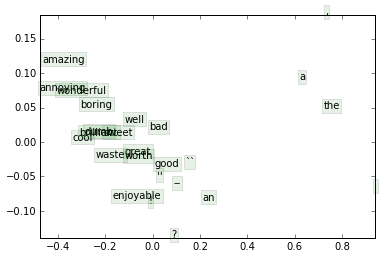

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize the word vectors you trained
_, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", 
	"good", "great", "cool", "brilliant", "wonderful", "well", "amazing",
	"worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", 
	"annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in xrange(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], 
    	bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))